In [1]:
import pennylane as qml
from gate_opt_utils_2 import *
import matplotlib.pyplot as plt
from penny_to_graph_31 import Penny_to_Graph
from graph_utils import *
from quantum_circuit_optimization import *

In [2]:
[ds] = qml.data.load("ketgpt")

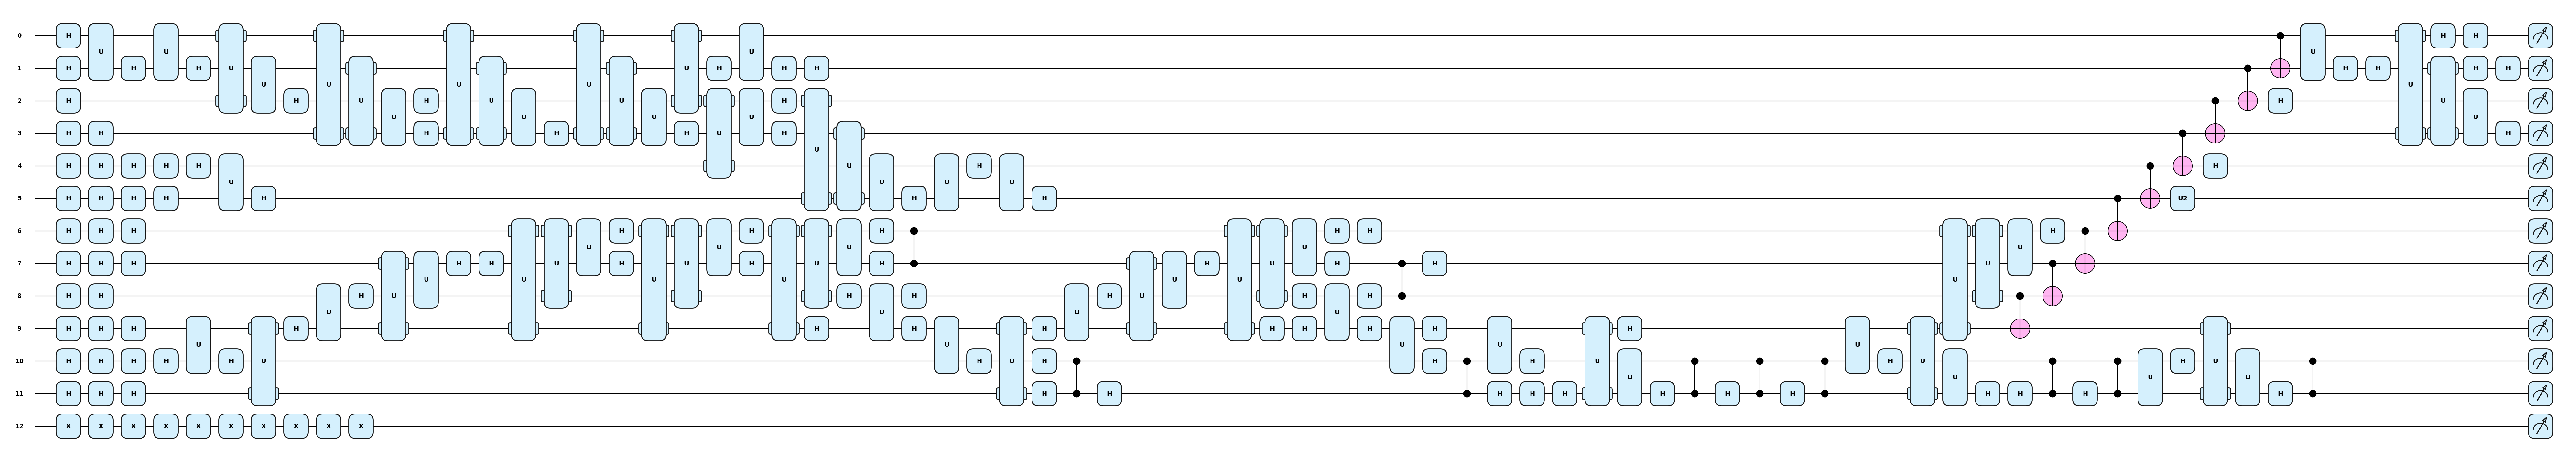

               0
num_qubit     13
num_gate     199
num_1q_gate  116
num_2q_gate   19
unitary       64
depth         66
None


In [3]:
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

print(summary_penny(circuit))

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         67
None


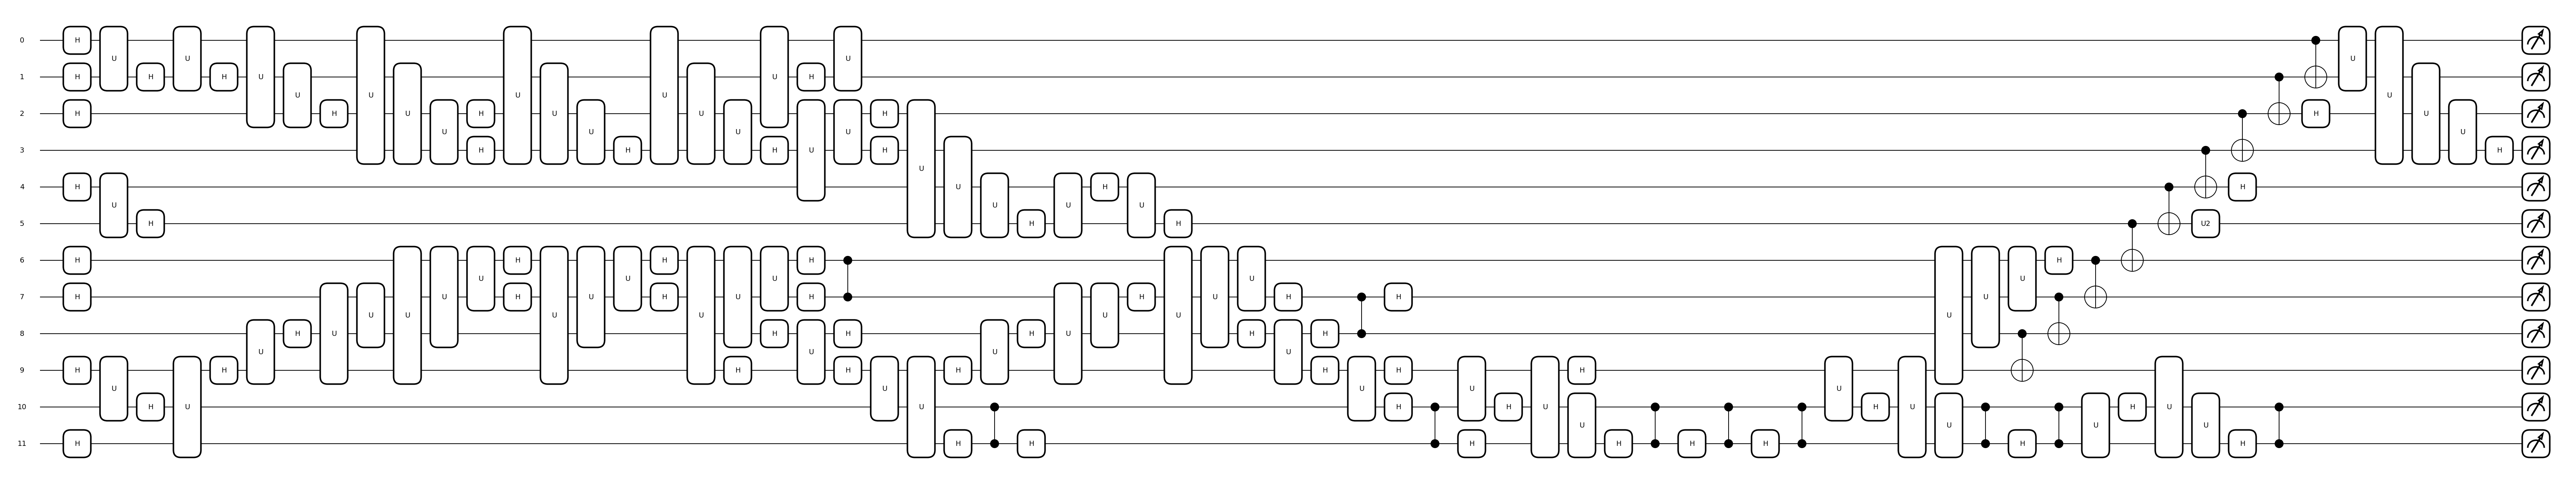

In [4]:
qnode = optimization_lev_1(ds, circuit, seed=0)

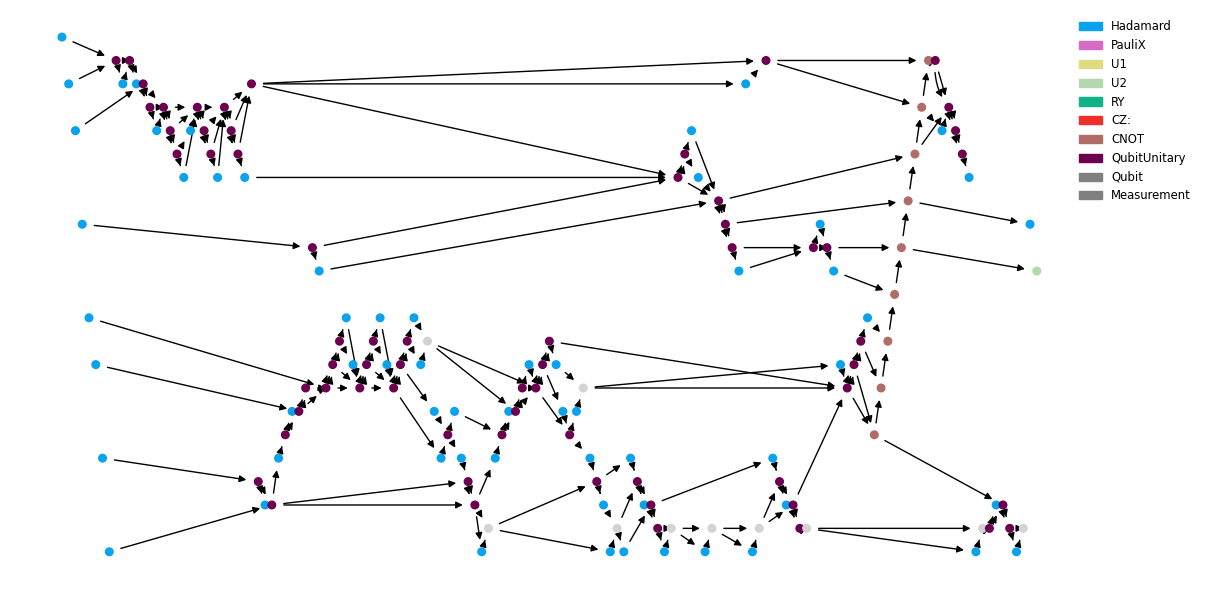

In [5]:
pg = Penny_to_Graph(qnode)
pg.show_graph(pg.G)

=== just a trial ! 

In [6]:
# methods combined
def remove_nodes(G_input, node_to_remove, by_label=False, pos_input=None, node_colors_input=None):
    if pos_input is None:
        pos_input = {}
    if node_colors_input is None:
        node_colors_input = {}

    # determine mode
    if by_label:
        nodes_to_remove = [n for n, attr in G_input.nodes(data=True) if attr.get('label') in node_to_remove]
    else:
        nodes_to_remove = [n for n in node_to_remove if n in G_input]

    G = G_input.copy()
    G.remove_nodes_from(nodes_to_remove)

    # Update pos and node_colors
    pos = {n: pos_input[n] for n in G.nodes if n in pos_input}
    if isinstance(node_colors_input, dict):
        node_colors = [node_colors_input[n] for n in G.nodes if n in node_colors_input]
    else:
        node_to_color = {n: node_colors_input[i] for i, n in enumerate(G_input.nodes)}
        node_colors = [node_to_color[n] for n in G.nodes if n in node_to_color]

    return [G, pos, node_colors]

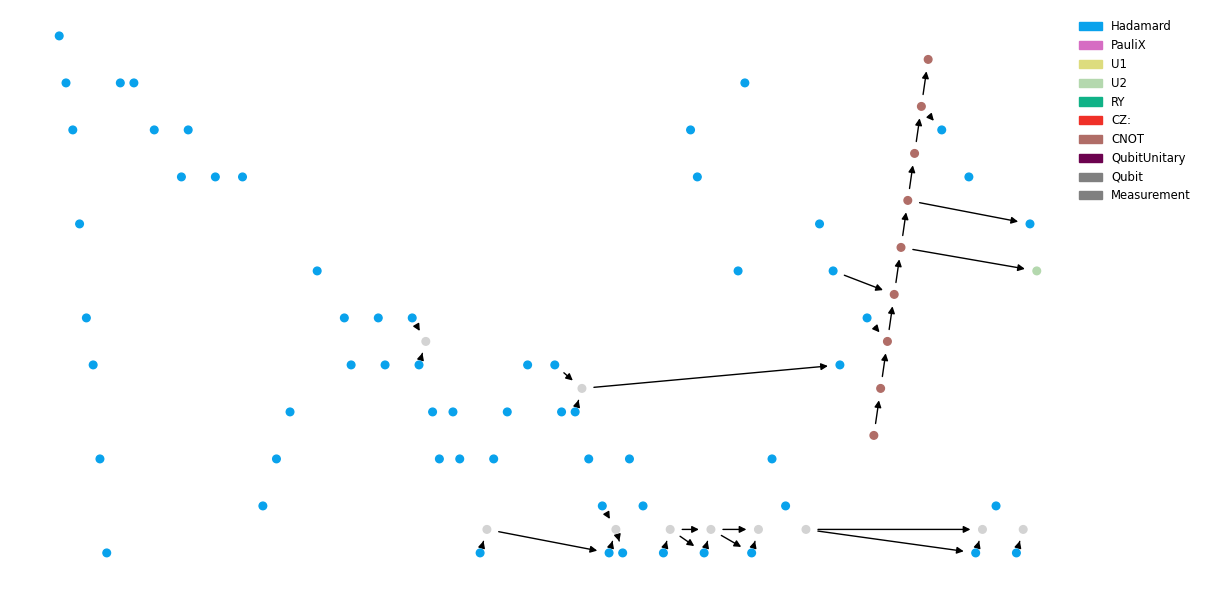

In [7]:
arr = remove_nodes(pg.G, node_to_remove=['QubitUnitary'], by_label=True, pos_input=pg.pos, node_colors_input=pg.node_colors)

pg.set_G(arr[0])
pg.set_pos(arr[1])
pg.set_node_colors(arr[2])
pg.show_graph(pg.G)

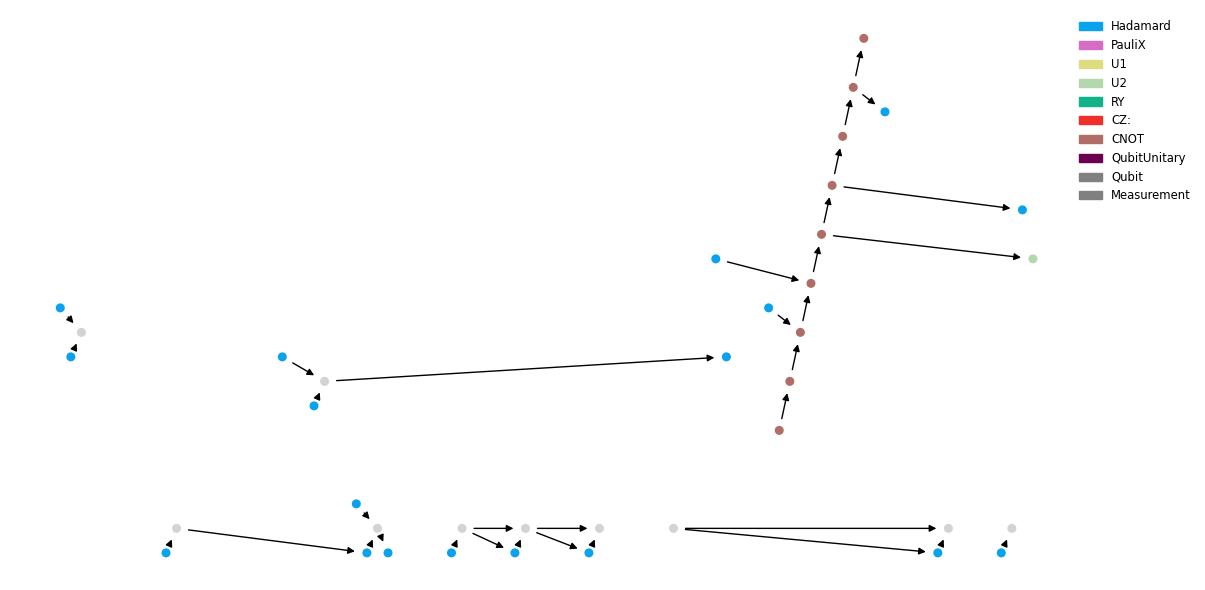

In [8]:
arr = remove_nodes(pg.G, node_to_remove=list(nx.isolates(pg.G)), by_label=False, pos_input=pg.pos, node_colors_input=pg.node_colors)

pg.set_G(arr[0])
pg.set_pos(arr[1])
pg.set_node_colors(arr[2])
pg.show_graph(pg.G)

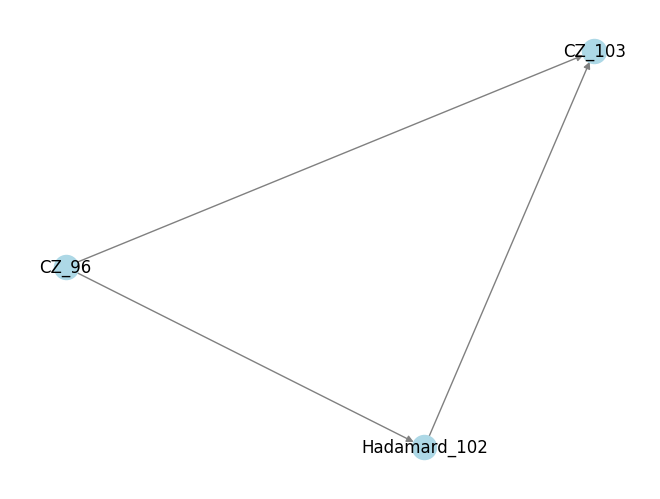

In [9]:
gate_2q = [n for n, attr in pg.G.nodes(data=True) if len(attr['wires'])==2]
radius = 10
center_node = gate_2q[5]
subG = nx.ego_graph(pg.G, center_node, radius=radius)
nx.draw(subG, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [10]:
# Get connected components
components = list(nx.connected_components(pg.G.to_undirected()))

# Print each component
for i, comp in enumerate(components[:5]):
    print(f"comp {i+1}: {comp}")

comp 1: {'CZ_54', 'Hadamard_52', 'Hadamard_53'}
comp 2: {'Hadamard_80', 'Hadamard_83', 'Hadamard_62', 'CZ_63', 'CZ_82', 'Hadamard_81'}
comp 3: {'Hadamard_76', 'CZ_77', 'Hadamard_115', 'Hadamard_73'}
comp 4: {'Hadamard_95', 'CZ_90', 'Hadamard_102', 'CZ_103', 'CZ_96', 'Hadamard_89'}
comp 5: {'CZ_110', 'Hadamard_135', 'CZ_136'}


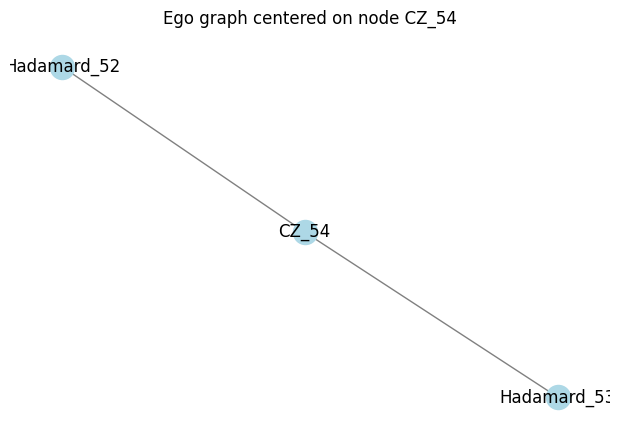

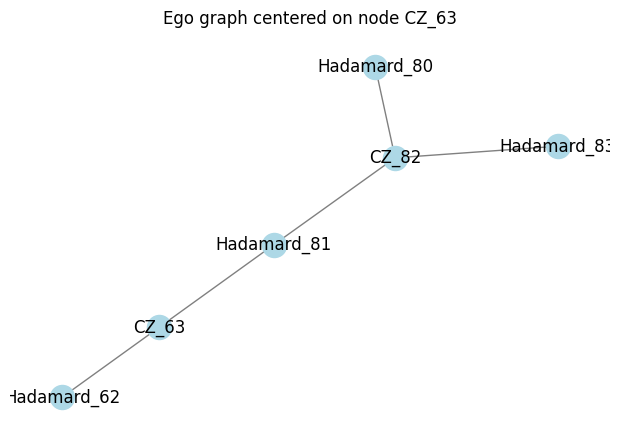

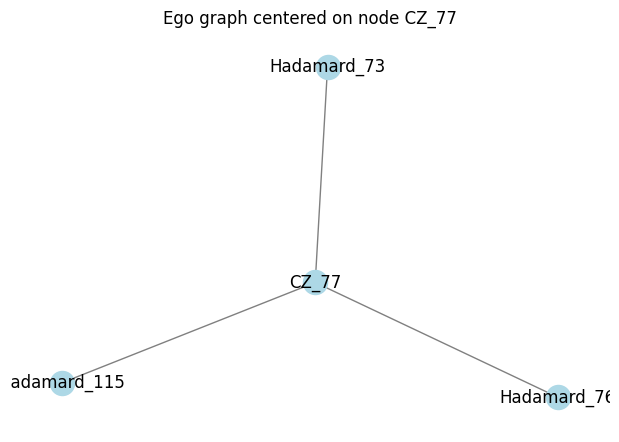

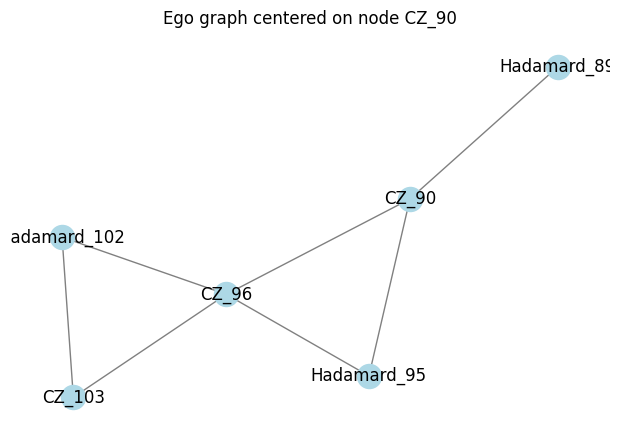

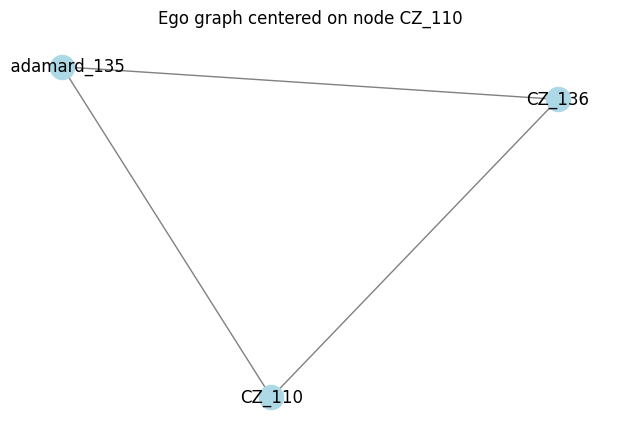

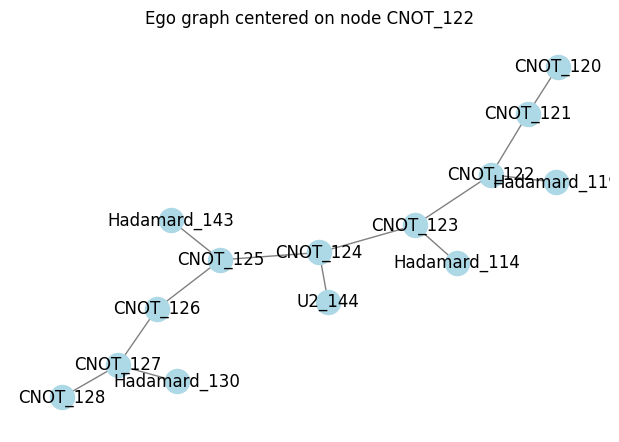

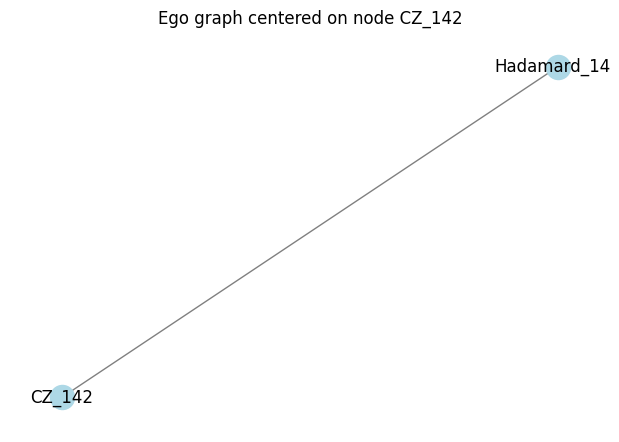

In [11]:
# graph needs transforming into an undirected on for these procedures!
components = list(nx.connected_components(pg.G.to_undirected()))
radius = 10 
subgraphs = []

for comp in components:
    candidate_nodes = [ # search for two-qubit gates
        n for n in comp
        if 'wires' in pg.G.nodes[n] and len(pg.G.nodes[n]['wires']) == 2
    ]

    if candidate_nodes: # draw ego graphs
        center_node = candidate_nodes[0]
        subG = nx.ego_graph(pg.G.to_undirected(), center_node, radius=radius)
        subgraphs.append(subG)

        plt.figure(figsize=(6, 4))
        nx.draw(subG, with_labels=True, node_color='lightblue', edge_color='gray')
        plt.title(f"Ego graph centered on node {center_node}")
        plt.show()

=== end of the trial. 😉 I prefer the following method based on ego graphs! 

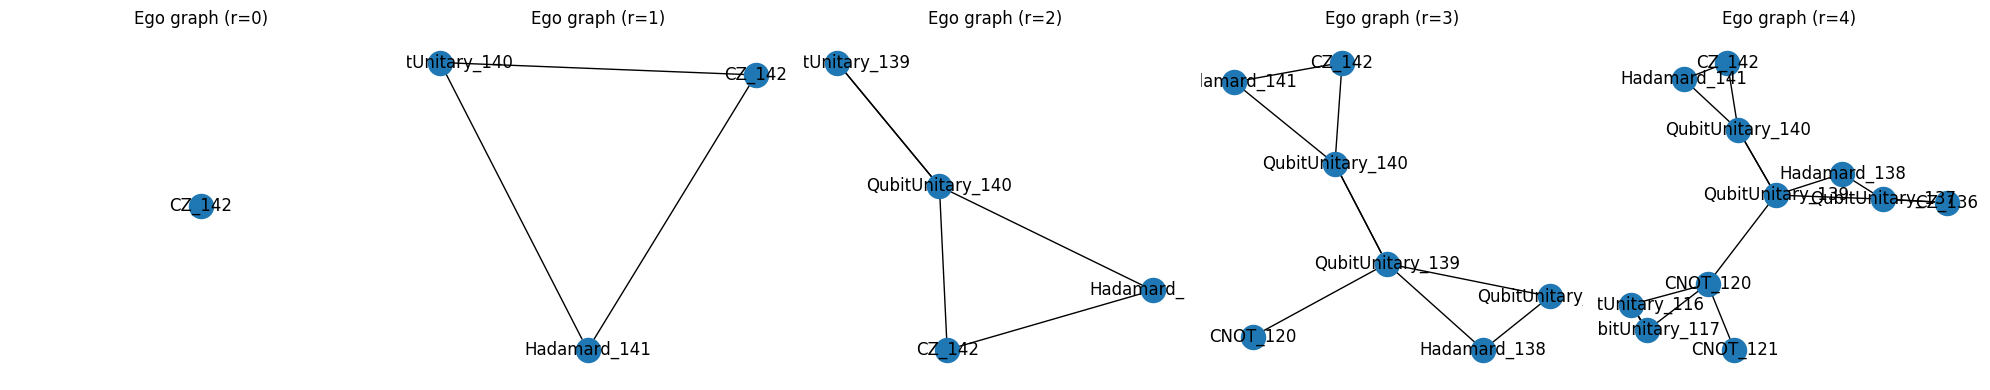

In [16]:
# get ego graphs of two-qubit gates without removing any
# examine how the gate changes with radius
# stop increasing the radius when neighbors' wires deviated from its own
gate_2q = [n for n, attr in pg.G.nodes(data=True) if attr['num_q']==2]
pg = Penny_to_Graph(qnode)
radius = 0

# for i in range(5):
#     subG = nx.ego_graph(pg.G.to_undirected(), center_node, radius=radius)
#     nx.draw(subG, with_labels=True)
#     plt.title(f'ego graph of {center_node}')
#     plt.show()
#     radius += 1

fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # 1 row, 5 columns
radius = 0
for i in range(5):
    subG = nx.ego_graph(pg.G.to_undirected(), center_node, radius=radius)
    ax = axes[i]
    nx.draw(subG, ax=ax, with_labels=True)
    ax.set_title(f'Ego graph (r={radius})')
    radius += 1
plt.tight_layout()
plt.show()

In [17]:
# we need to conduct backtracking
subgraphs = []
gate_2q = [n for n, attr in pg.G.nodes(data=True) if attr['num_q'] == 2]

for center in gate_2q:
    radius = 0
    wires = pg.G.nodes[center]['wires']
    prev_subG = None

    while True:
        bool_list = []
        subG = nx.ego_graph(pg.G.to_undirected(), center, radius=radius)
        for node, attr in subG.nodes(data=True):
            bool_list.append(set(attr['wires']).issubset(wires))        

        if bool_list.count(False) > 1:
            if prev_subG is not None:
                subgraphs.append({'center': center, 'wires':wires, 'subG': prev_subG})
            break
        else:
            prev_subG = subG 
            radius += 1

In [18]:
def draw_subgraphs(subgraphs):
    num_subgraphs = len(subgraphs)
    cols = 5
    rows = (num_subgraphs + cols - 1) // cols 

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  
    axes = axes.flatten()  

    for i in range(num_subgraphs):
        nx.draw(subgraphs[i]['subG'], ax=axes[i], with_labels=True)
        axes[i].set_title(subgraphs[i]['center'])

    # Hide any unused axes
    for j in range(num_subgraphs, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

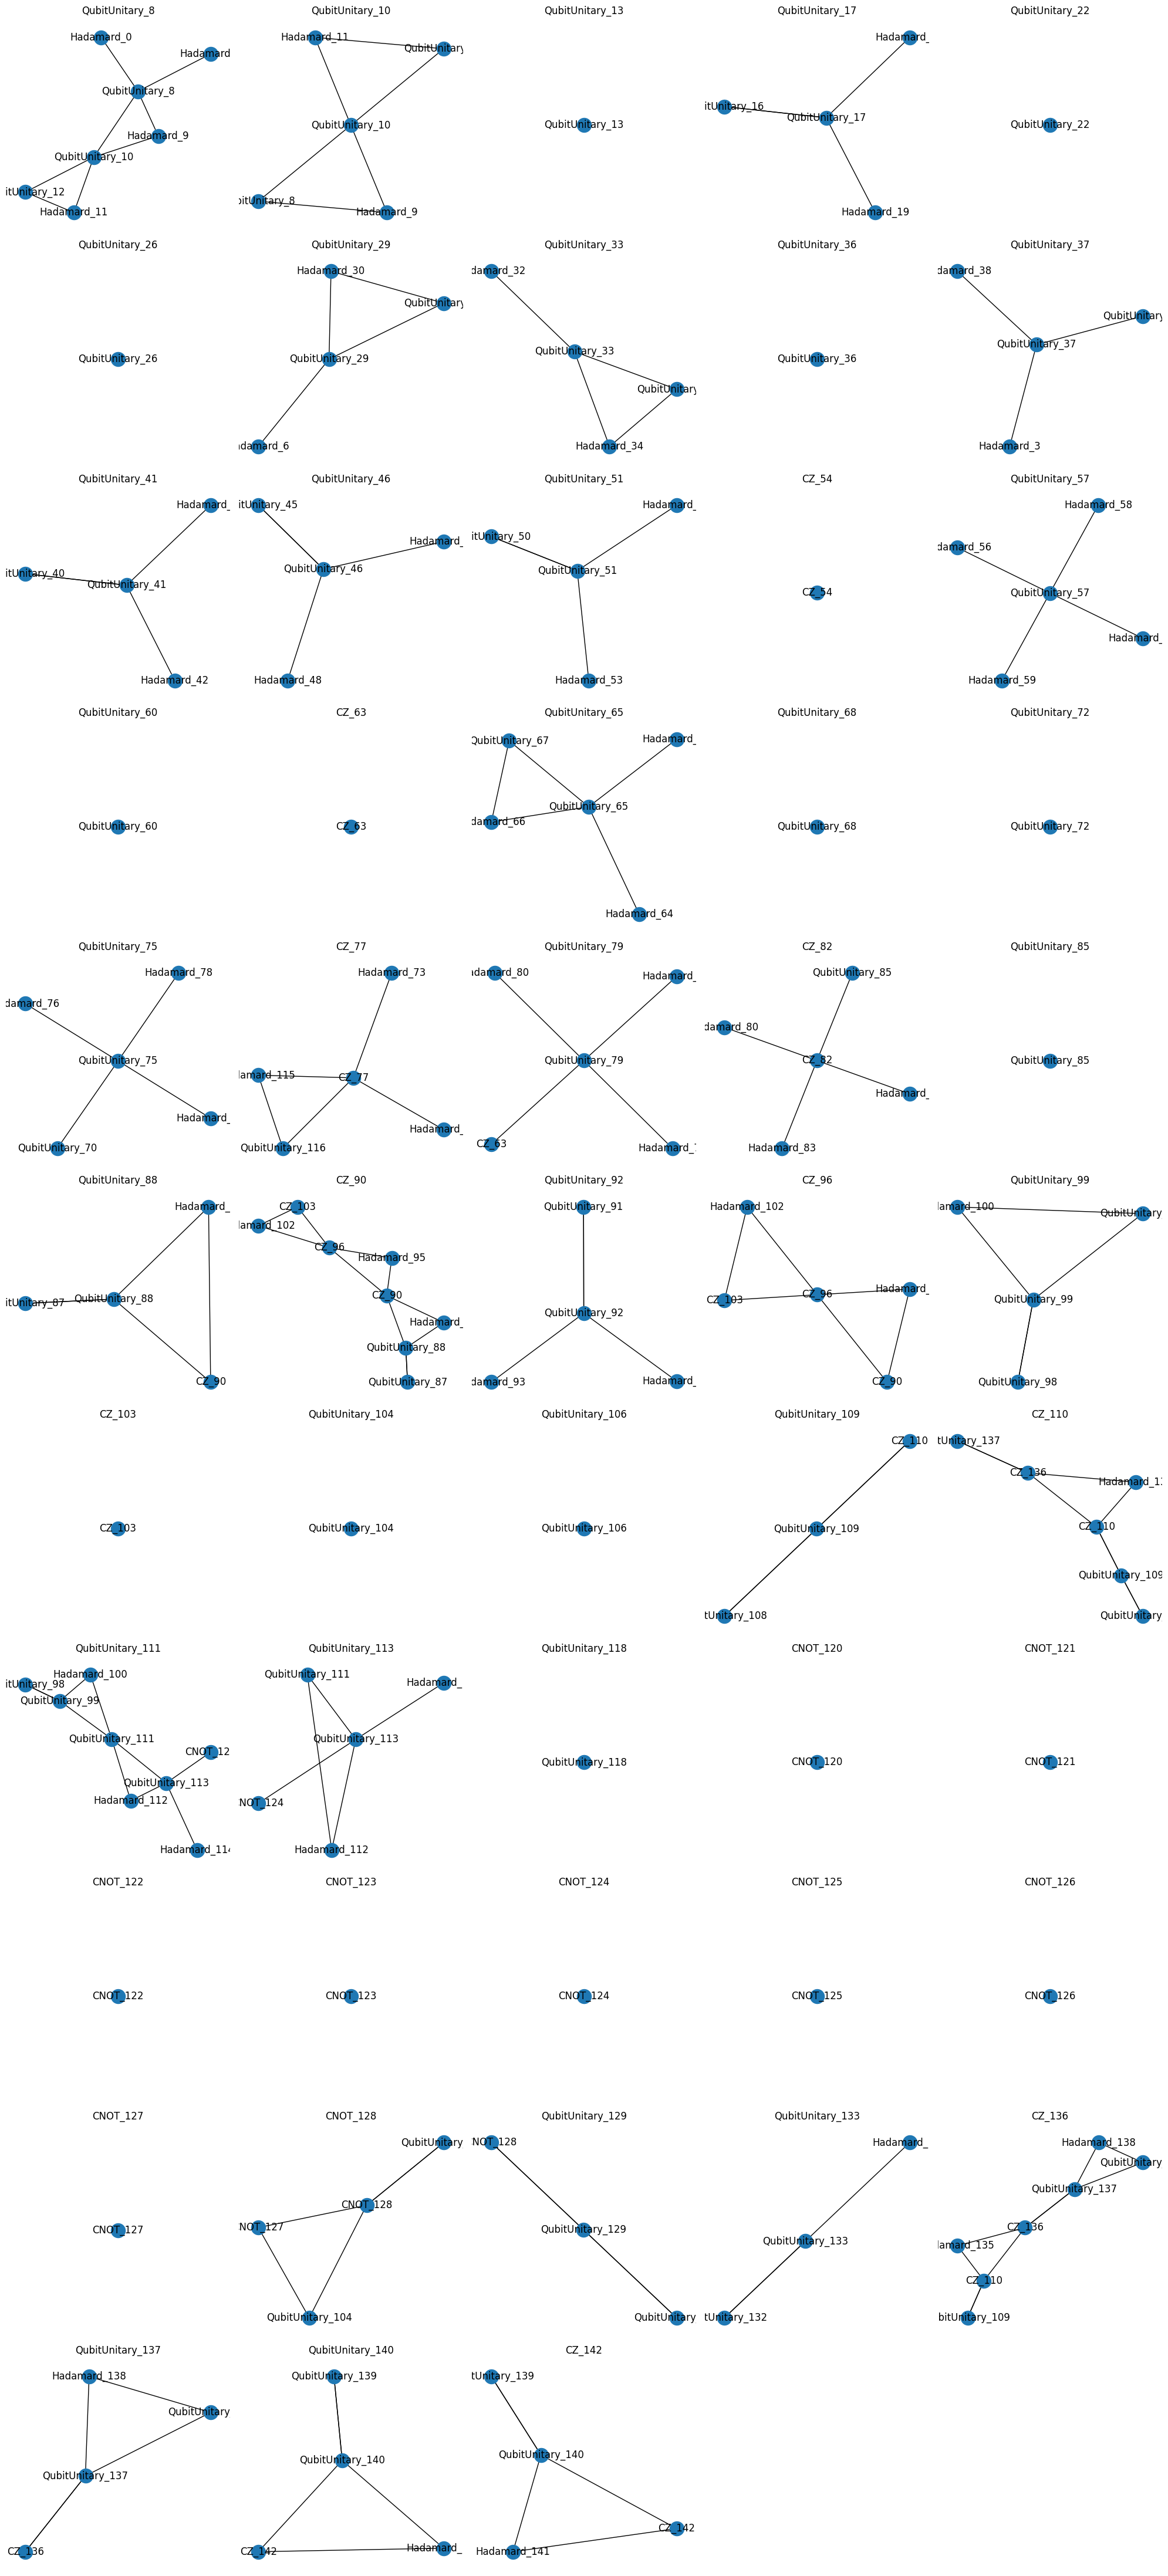

In [19]:
draw_subgraphs(subgraphs)

In [20]:
# change the subgraphs
new_subgraph = subgraphs.copy()
# drop standalone nodes
effective_idx = []
for idx, elem in enumerate(subgraphs):
    if len(elem['subG'].nodes()) == 1:
        continue
    else:
        effective_idx.append(idx)

new_subgraph = [new_subgraph[i] for i in effective_idx]

for idx, elem in enumerate(new_subgraph):
    reference_wires = elem['wires']
    subG = elem['subG'] 
    # remove nodes outside the ference wires
    nodes_to_remove = [
        node for node, attr in subG.nodes(data=True)
        if not set(attr.get('wires', [])).issubset(reference_wires)
    ]
    subG.remove_nodes_from(nodes_to_remove)
    new_subgraph[idx]['subG'] = subG

In [21]:
# concisely,
new_subgraph = [elem for elem in subgraphs if len(elem['subG'].nodes()) > 1]
for elem in new_subgraph:
    reference_wires = set(elem['wires'])
    subG = elem['subG']
    nodes_to_remove = [node for node, attr in subG.nodes(data=True) if not set(attr.get('wires', [])).issubset(reference_wires)]
    subG.remove_nodes_from(nodes_to_remove)

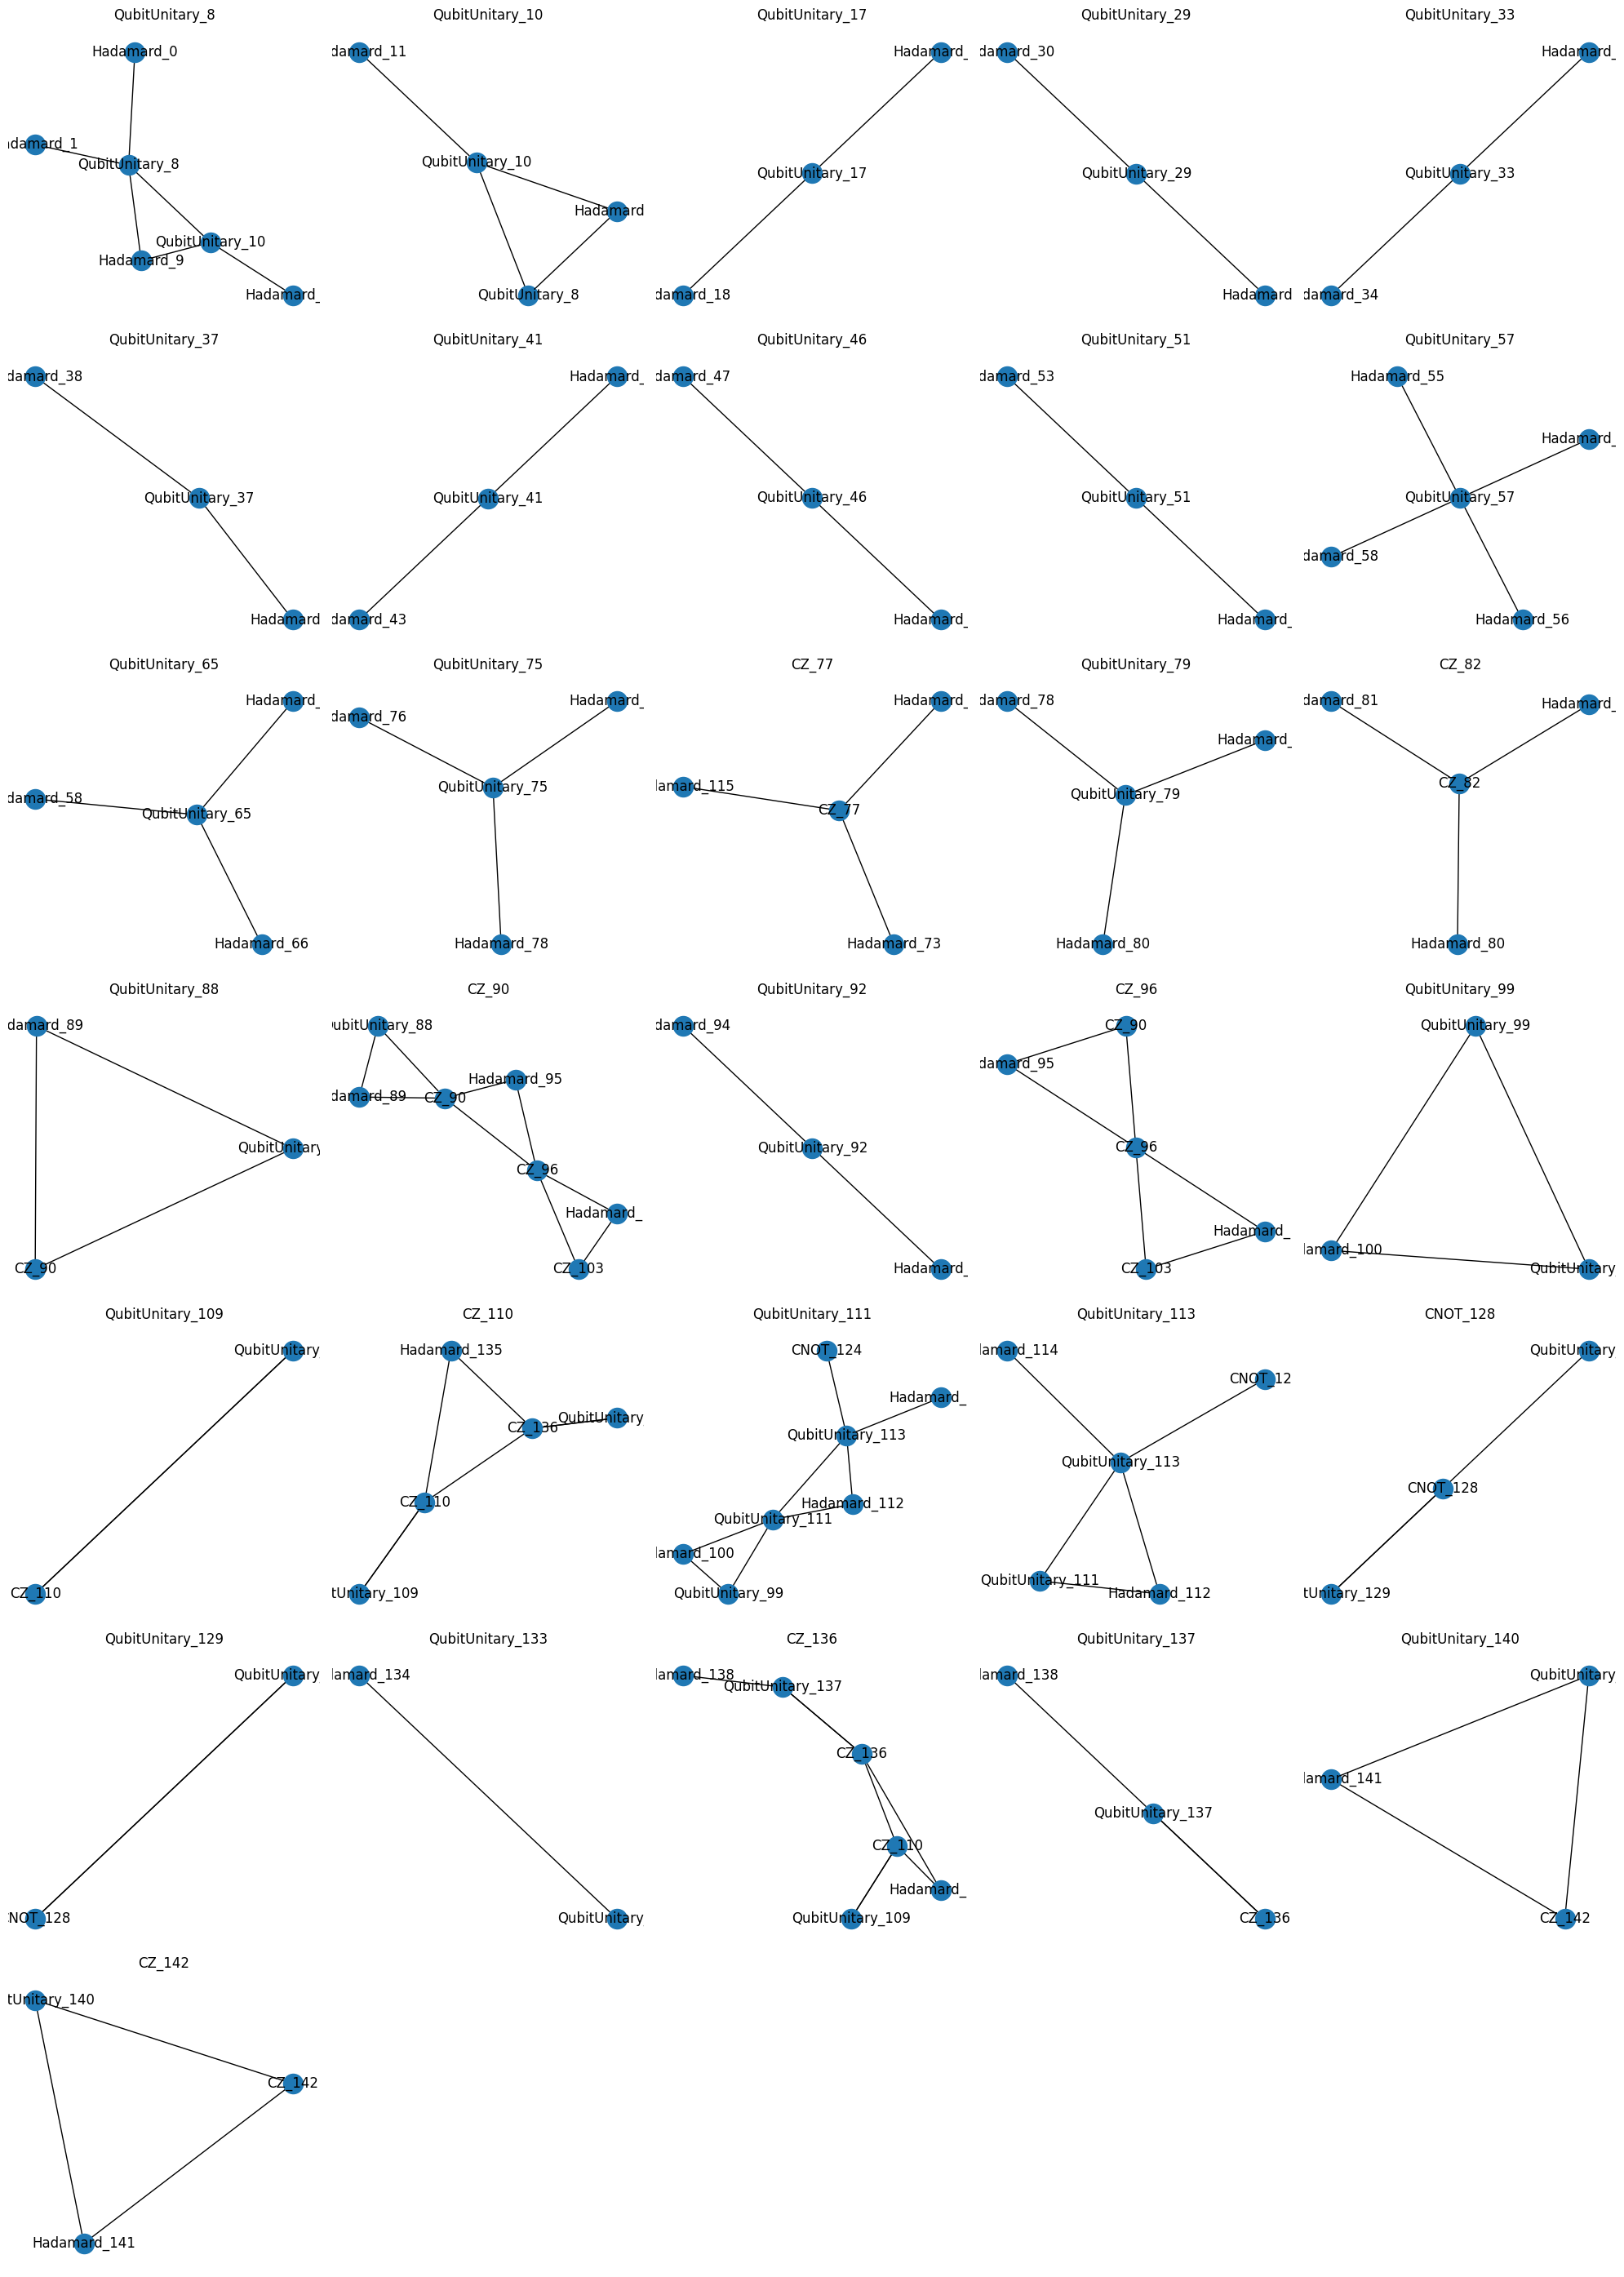

In [22]:
draw_subgraphs(new_subgraph)

In [23]:
unique_subgraphs = []

for candidate in new_subgraph:
    subG = candidate['subG']
    is_duplicate = any(nx.is_isomorphic(subG, existing['subG']) for existing in unique_subgraphs)
    
    if not is_duplicate:
        unique_subgraphs.append(candidate)

print(len(new_subgraph))
print(len(unique_subgraphs))

31
15


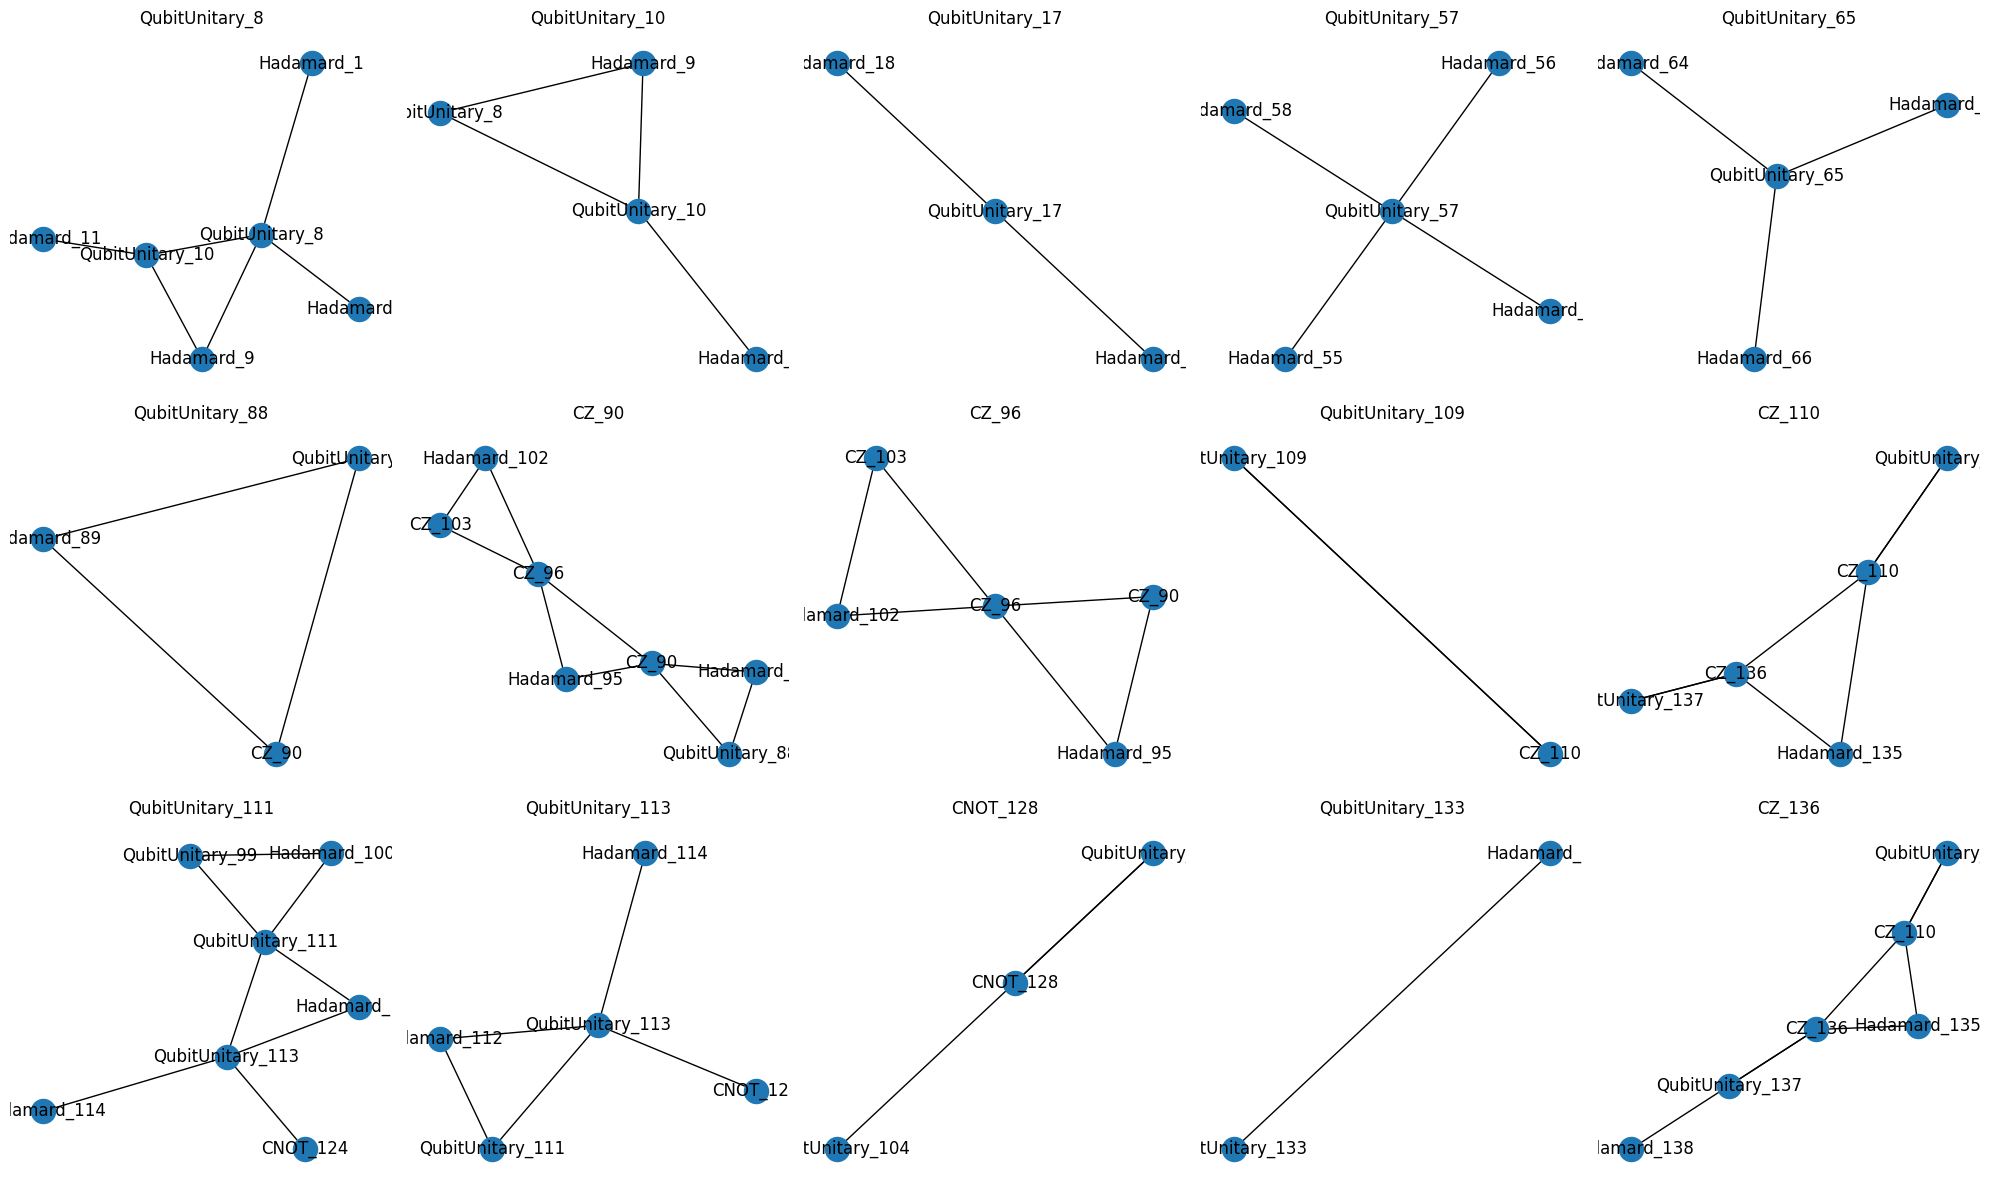

In [24]:
draw_subgraphs(unique_subgraphs)